In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt

#### Word2Vec
import gensim
from gensim.models import Word2Vec

####
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torchutils as tu
from sklearn.model_selection import train_test_split
from collections import Counter

from torchmetrics.classification import BinaryAccuracy
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
df = pd.read_json('/home/nikita/ds-phase-2/10-nlp/NLP-proj/data/healthcare_facilities_reviews.jsonl', lines=True)[['content', 'sentiment']]
X_train, X_val, y_train, y_val = train_test_split(df['content'], df['sentiment'])

In [17]:
from transformers import AutoTokenizer, AutoModel

device = 'cuda'
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
model.to(device)  # uncomment it if you have a GPU

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(83828, 312, padding_idx=0)
    (position_embeddings): Embedding(2048, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)

In [18]:
encoded_train = X_train.apply(
    lambda x: tokenizer(x, max_length=64, truncation=True, padding='max_length')
).values

encoded_val = X_val.apply(
    lambda x: tokenizer(x, max_length=64, truncation=True, padding='max_length')
).values

In [19]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder


class BertInputs(Dataset):
    def __init__(self, encoded_tweets, labels):
        super().__init__()
        self.inputs = encoded_tweets
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        item = self.inputs[idx]  
        
        input_ids = torch.tensor(item['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(item['attention_mask'], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)


train_bert = BertInputs(encoded_train, y_train)
val_bert = BertInputs(encoded_val, y_val)
train_loader = DataLoader(train_bert, shuffle=True, batch_size=64)
val_loader = DataLoader(val_bert, shuffle=True, batch_size=64)

In [20]:
class MyTinyBERT(nn.Module):
    def __init__(self, num_classes: int = 2, dropout: float = 0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
        
        # Размораживаем последние 2 слоя BERT для тонкой настройки
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True
        
        # Получаем размерность скрытого слоя из конфигурации
        hidden_size = self.bert.config.hidden_size
        
        # Упрощённый и более стабильный классификатор
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)  # Выходы для 2 классов (без сигмоиды!)
        )
        
        self.num_classes = num_classes

    def forward(self, batch):
        # Явно извлекаем нужные поля и перемещаем на устройство
        input_ids = batch['input_ids'].to(self.bert.device)
        attention_mask = batch['attention_mask'].to(self.bert.device)
        
        # Пропускаем через BERT (градиенты включены для размороженных слоёв)
        bert_out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Берём CLS-вектор (первый токен)
        cls_output = bert_out.last_hidden_state[:, 0, :]  # [B, hidden_size]
        
        # Убираем нормализацию — она может навредить
        # normed_output = nn.functional.normalize(cls_output, dim=1)
        
        # Пропускаем через классификатор
        logits = self.classifier(cls_output)
        return logits

In [21]:
from torchmetrics.classification import F1Score

model = MyTinyBERT()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
metric = F1Score(task="binary", num_classes=2, average="macro").to(device)

In [22]:
from time import time
import numpy as np

def fit(
        epochs: int,
        model: torch.nn.Module,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
        criterion,
        metric
        ):
    epoch_train_losses = []
    epoch_valid_losses = []
    epoch_train_metric = []
    epoch_valid_metric = []
    time_start = time()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    for epoch in range(epochs):
        batch_losses = []
        batch_metric = []

        # Обучение
        model.train()
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
            output = model(inputs).squeeze()  # [B, 2] — логиты

            loss = criterion(output, labels)  # CrossEntropyLoss: логиты + индексы
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Преобразуем логиты в классы для метрики
            preds = output.argmax(dim=1)  # [B] — индексы (0 или 1)
            batch_losses.append(loss.item())
            batch_metric.append(metric(preds, labels).item())

        epoch_train_losses.append(np.mean(batch_losses))
        epoch_train_metric.append(np.mean(batch_metric))

        # Валидация
        batch_losses = []
        batch_metric = []
        model.eval()
        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)


                inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
                output = model(inputs).squeeze()
                loss = criterion(output, labels)


                # Аналогично: логиты → классы
                preds = output.argmax(dim=1)
                batch_losses.append(loss.item())
                batch_metric.append(metric(preds, labels).item())


        epoch_valid_losses.append(np.mean(batch_losses))
        epoch_valid_metric.append(np.mean(batch_metric))


        print(f'Epoch {epoch+1}')
        print(f'train_loss : {epoch_train_losses[-1]:.4f} val_loss : {epoch_valid_losses[-1]:.4f}')
        print(f'train_f1 : {epoch_train_metric[-1]:.2f} val_f1 : {epoch_valid_metric[-1]:.2f}')
        print(25*'==')


    training_time = time() - time_start
    return (epoch_train_losses, epoch_valid_losses,
             epoch_train_metric, epoch_valid_metric, training_time)


In [23]:
train_losses, val_losses, train_metric, val_metric, rnn_time = fit(3, model, train_loader, val_loader, optimizer, criterion, metric)

Epoch 1
train_loss : 0.2995 val_loss : 0.2452
train_f1 : 0.89 val_f1 : 0.91
Epoch 2
train_loss : 0.2503 val_loss : 0.2333
train_f1 : 0.91 val_f1 : 0.92
Epoch 3
train_loss : 0.2268 val_loss : 0.2385
train_f1 : 0.92 val_f1 : 0.91


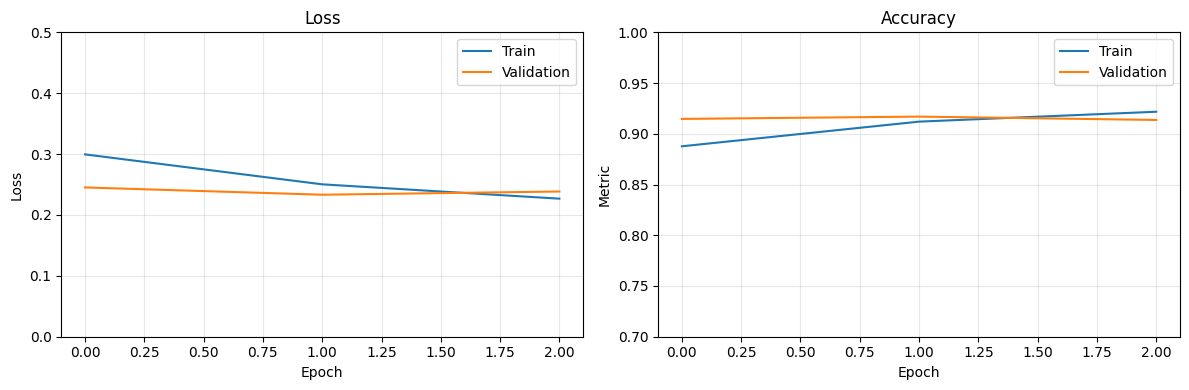

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 0.5)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_metric, label='Train')
plt.plot(val_metric, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.ylim(0.7, 1)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

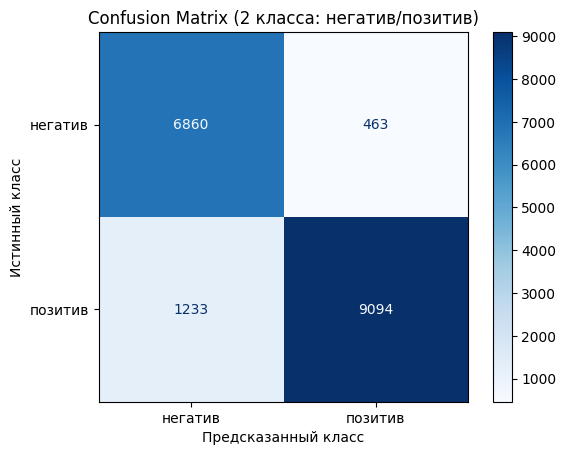

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        logits = model({'input_ids': input_ids, 'attention_mask': attention_mask})
        preds = logits.argmax(dim=1)  # argmax по 2 классам


        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Для 2 классов: 0 — негатив, 1 — позитив
classes = [0, 1]
class_names = ['негатив', 'позитив']  # для подписей на графике


# Строим матрицу путаницы (явно указываем 2 класса)
cm = confusion_matrix(all_labels, all_preds, labels=classes)

# Визуализация
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names  # подписи на осях
)
disp.plot(cmap='Blues', values_format='d')  # values_format='d' — целые числа
plt.title('Confusion Matrix (2 класса: негатив/позитив)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()


In [ ]:
int_to_vocab = {j:i for i, j in vocab_to_int.items()}

In [ ]:
def plot_and_predict(review, SEQ_LEN, model):
    # Препроцессинг текста
    processed_review = data_preprocessing(review)
    words = processed_review.split()[:SEQ_LEN]
    
    # Конвертируем слова в индексы
    sequence = []
    for word in words:
        if word in vocab_to_int:
            sequence.append(vocab_to_int[word])
        else:
            sequence.append(vocab_to_int['<UNK>'])  # если есть UNK токен
    
    # Добавляем padding если нужно
    if len(sequence) < SEQ_LEN:
        sequence = sequence + [0] * (SEQ_LEN - len(sequence))  # 0 = <PAD>
    
    # Создаем тензор
    inp = torch.tensor(sequence).unsqueeze(0)  # (1, seq_len)
    
    # Предсказание
    model.eval()
    with torch.no_grad():
        pred, att_weights = model(inp)
        pred_class = pred.sigmoid().round().item()
        att_scores = att_weights[0]  # (seq_len,)
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    
    # Фильтруем padding токены
    valid_indices = [i for i, idx in enumerate(sequence) if idx != 0]  # индексы не-padding токенов
    valid_words = [int_to_vocab[sequence[i]] for i in valid_indices]
    valid_scores = att_scores[valid_indices]
    
    # График внимания
    plt.bar(range(len(valid_words)), valid_scores.cpu().numpy(), alpha=0.7, color='skyblue')
    plt.xticks(ticks=range(len(valid_words)), labels=valid_words, rotation=45, ha='right')
    plt.ylabel('Attention Weight')
    plt.title(f'Predicted class: {int(pred_class)} ({"Positive" if pred_class == 1 else "Negative"})')
    plt.tight_layout()
    plt.show()
    
    print(f"Review: {review}")
    print(f"Processed: {processed_review}")
    print(f"Prediction: {pred_class} (Probability: {pred.sigmoid().item():.4f})")
    print("\nTop words by attention:")
    for word, score in sorted(zip(valid_words, valid_scores.cpu().numpy()), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {word}: {score:.4f}")

In [ ]:
review = "Клиника так себе, мне не очень понравилось"
plot_and_predict(
    review = review, 
    SEQ_LEN=len(review.split()),
    model = model
)

In [26]:
torch.save(model.state_dict(), "/home/nikita/ds-phase-2/10-nlp/NLP-proj/models/ML+LSTM+Bert/my_tinybert_finetuned.pth")
torch.save({'num_classes': 2, 'dropout': 0.3}, "/home/nikita/ds-phase-2/10-nlp/NLP-proj/models/ML+LSTM+Bert/my_tinybert_config.pth")
tokenizer.save_pretrained("/home/nikita/ds-phase-2/10-nlp/NLP-proj/models/ML+LSTM+Bert")

('/home/nikita/ds-phase-2/10-nlp/NLP-proj/models/ML+LSTM+Bert/tokenizer_config.json',
 '/home/nikita/ds-phase-2/10-nlp/NLP-proj/models/ML+LSTM+Bert/special_tokens_map.json',
 '/home/nikita/ds-phase-2/10-nlp/NLP-proj/models/ML+LSTM+Bert/vocab.txt',
 '/home/nikita/ds-phase-2/10-nlp/NLP-proj/models/ML+LSTM+Bert/added_tokens.json',
 '/home/nikita/ds-phase-2/10-nlp/NLP-proj/models/ML+LSTM+Bert/tokenizer.json')